In [1]:
# packages = ('pytorch_lightning timm==0.6.12 ipywidgets==7.7.1 opencv-python zstandard awscli ' 
#                     +  'transformers librosa torchlibrosa torchaudio torchvision ' 
#                     + 'lion-pytorch segmentation-models-pytorch==0.3.2 ' 
#                     'fcwt') # fsspec[s3] albumentations==1.3.0 
# !pip install -q -U $packages

In [2]:
# FAST = False
SAMPLE = 4

In [3]:
# DATA_PATH = '/data/'
DATASET = 'walkdata4'
TAG = 'tlvmc-parkinsons-freezing-gait-prediction'
INPUT_PATH = '/kaggle/input/' + TAG
DATA_PATH = '/tmp/'
CODE_PATH = '/kaggle/input/' + DATASET
PREFIX = 'walk/'
OFFLINE = True

In [4]:
!ls $CODE_PATH

dataset.py  model.py  models  params  run.py  smp  whl


In [5]:
WHEEL_PATH = CODE_PATH + '/whl'
import os
for p in os.listdir(WHEEL_PATH):
    if 'segment' in p: continue; 
    !pip install {WHEEL_PATH}/{p}

Processing /kaggle/input/walkdata4/whl/timm-0.6.12-py3-none-any.whl
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2


In [6]:
import sys
sys.path.append(CODE_PATH + '/smp')
# import segmentation_models_pytorch as smp
# smp.Unet(encoder_weights = None);

In [7]:
import zipfile
import boto3
s3 = boto3.client('s3')

import os
import io
from joblib import Parallel, delayed

import json
import pickle
import zstandard as zstd
zd = zstd.ZstdDecompressor()
zc = zstd.ZstdCompressor()

import math
import random
import datetime

In [8]:
# walk and list all files
objs = []
for root, path, files in os.walk(INPUT_PATH):
    if 'train' in root: continue
    objs.extend([os.path.join(root, f).replace(INPUT_PATH + '/', '') for f in files])
    print(root, len(files))
len(objs)

/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction 7
/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/unlabeled 65
/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test 0
/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog 1
/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog 1


74

In [9]:
def getFile(file, save = True):
#     s3 = boto3.client('s3')
#     zd = zstd.ZstdDecompressor()
#     file_path = DATA_PATH + 'data/' + file + '.zstd'
#     if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
#         if save: os.makedirs(os.path.dirname(file_path), exist_ok=True)
#         fin = s3.get_object(Bucket = DATA_BUCKET, Key = PREFIX + 'data/' + file + '.zstd')['Body']#.read()        
#         if save:
#             with open(file_path, 'wb') as f: f.write(fin.read())
    file_path = os.path.join(INPUT_PATH, file)# + '.zstd'
    out = io.BytesIO()
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        with open(file_path, 'rb') as fin:
#             zd.copy_stream(fin, out)
#     else:        
            out.write(fin.read())
    out.seek(0)
    # print(out.getbuffer().nbytes)
    return out

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 4)

from IPython.display import display
np.random.seed(datetime.datetime.now().microsecond)

In [11]:
files = sorted(objs)#o)[0] for o in objs])
display(files[:10])

events = pd.read_csv(getFile('events.csv'))
subjects = pd.read_csv(getFile('subjects.csv'))
tasks = pd.read_csv(getFile('tasks.csv'))
daily_metadata = pd.read_csv(getFile('daily_metadata.csv'))
defog_metadata = pd.read_csv(getFile('defog_metadata.csv'))
tdcsfog_metadata = pd.read_csv(getFile('tdcsfog_metadata.csv'))
sample = pd.read_csv(getFile('sample_submission.csv'), index_col = 0, 
                    ).astype(np.float32)

['daily_metadata.csv',
 'defog_metadata.csv',
 'events.csv',
 'sample_submission.csv',
 'subjects.csv',
 'tasks.csv',
 'tdcsfog_metadata.csv',
 'test/defog/02ab235146.csv',
 'test/tdcsfog/003f117e14.csv',
 'unlabeled/00c4c9313d.parquet']

In [12]:
def prep_metadata(defog_metadata, tdcsfog_metadata, daily_metadata, subjects, full = True,
                    expanded = True):
    m1 = defog_metadata.copy()
    m1.insert(3, 'Test', 0)
    m1 = m1.merge(subjects, on = ['Subject', 'Visit', ], how = 'inner')
    assert len(m1) == len(defog_metadata)

    m2 = tdcsfog_metadata.copy()
    m2 = m2.merge(subjects.drop(columns = 'Visit'), on = ['Subject', ], how = 'inner')
    assert len(m2) == len(tdcsfog_metadata)

    m3 = daily_metadata.copy()
    m3 = m3.merge(subjects, on = ['Subject', 'Visit' ], how = 'inner')
    m3.insert(3, 'Test', 0)
    m3.insert(4, 'Medication', (defog_metadata.Medication == 'on').mean())
    m3.drop(columns = [c for c in m3.columns if 'recording' in c], inplace = True)
    assert len(m3) == len(daily_metadata)

    metadata = pd.concat([m1, m2, #m3
                            ], axis = 0)
    metadata.Medication = 1 * (metadata.Medication == 'on')
    metadata.Sex = 1 * (metadata.Sex == 'M')
    
    if expanded:
        metadata['num_tests'] = metadata.groupby('Subject').transform(lambda x: x.nunique()).Test
        metadata['max_visit'] = metadata.groupby('Subject').transform(lambda x: x.max()).Visit
        metadata['visit_medications'] = metadata.groupby(['Subject', 'Visit']).transform('nunique').Medication 
        metadata['UPDRS_On_vs_Off'] = metadata.UPDRSIII_On - metadata.UPDRSIII_Off
        # add 4 columns to dmetadata
    

    if full:
        # null fix
        metadata['Uon_null'] = 1 * (metadata.UPDRSIII_On.isnull())
        metadata['Uoff_null'] = 1 * (metadata.UPDRSIII_Off.isnull())
        metadata.UPDRSIII_On = metadata.UPDRSIII_On.fillna(metadata.UPDRSIII_On.mean())
        metadata.UPDRSIII_Off = metadata.UPDRSIII_Off.fillna(metadata.UPDRSIII_Off.mean())
        if expanded:
            metadata.UPDRS_On_vs_Off = metadata.UPDRS_On_vs_Off.fillna(metadata.UPDRS_On_vs_Off.mean())   

    metadata.set_index('Id', inplace = True)
    
    if full:
        metadata['Test_Nonzero'] = 1. * (metadata.Test > 0)
        # for i in range(1):
        #     metadata['Test{}'.format(i)] = metadata.Test == i
        metadata.iloc[:, 1:] = metadata.iloc[:, 1:].astype(np.float32)
        metadata.iloc[:, 1:] = (metadata.iloc[:, 1:] - metadata.iloc[:, 1:].mean(0)) / metadata.iloc[:, 1:].std(0)  
        metadata.iloc[:, 1:] = metadata.iloc[:, 1:].clip(-3, 3)

    msubject = metadata.Subject
    metadata.drop(columns = 'Subject', inplace = True)
    if full:
        metadata = metadata.astype(np.float32)
    
    m3 = m3.set_index('Id')
    assert m3.shape[1] <= metadata.shape[1]; i = 0
    while m3.shape[1] < metadata.shape[1]:
        m3.insert(m3.shape[1], 'dummy_{}'.format(i), 0); i += 1
    m3.iloc[:, -1] = metadata.iloc[:, -1].min() # yes, hack, for default_metadata in dataset.py 

    return metadata, msubject, m3

In [13]:
fog_files = sorted([f for f in files if 'test/' in f and 'fog' in f])
# if FAST and len(fog_files) == 2:
#     fog_files = [f for f in fog_files if 'tdcs' in f]
print(len(fog_files))

unlabeled_files = [f for f in files if 'unlabeled/' in f]# and not any([z in f for z in common_files])]
print(len(unlabeled_files))

2
65


In [14]:
# load and process data
def load(f):
    return np.load(DATA_PATH + 'cache/' + f + '.npy')

def process(f):
    # if exists, return stats
    cache_file = DATA_PATH + 'cache/' + f + '.npy'
    if os.path.exists(cache_file) and os.path.getsize(cache_file) > 0: 
        return load(f).shape, os.path.getsize(cache_file)
    
    # if not, load array,
    df = pd.read_csv(getFile(f, ), )
#     print(df)
    assert (df.index == df.Time).all()
    # verify
    assert (df.Time == df.index).all()
    assert all(df.columns == ['Time',
                           'AccV', 'AccML', 'AccAP',
                           'StartHesitation', 'Turn', 'Walking',
                            'Valid', 'Task'][:len(df.columns)])
    if 'train/' not in f: assert len(df.columns) in [4]
    
    v = np.zeros((len(df), 12), dtype = np.float32)
    v[:, 6:8] = 1
    v[:, :df.shape[1] - 1] = df.iloc[:, 1:]

#     fid = f.split('/')[-1].split('.')[0]
#     mult = 100 if 'tdcs' not in f else 128
#     for e in events[events.Id == fid].itertuples():
#         v[int(round(e.Init * mult)): int(round(e.Completion * mult)), 8] = 1
#         v[int(round(e.Init * mult)): int(round(e.Completion * mult)), 9] = e.Kinetic
#         v[int(round(e.Init * mult)): int(round(e.Completion * mult)), 10] = 1 - e.Kinetic
#     for e in tasks[tasks.Id == fid].itertuples():
#         v[int(round(e.Begin * mult)): int(round(e.End * mult)), 11] = task_dict[e.Task]

    # store as compresssed;
    assert v.dtype == np.float32
    # zc = zstd.ZstdCompressor()
    # compr = zc.compress(pickle.dumps(v))
    os.makedirs(os.path.dirname(cache_file), exist_ok = True)
    np.save(cache_file, v)
    # with open(cache_file, 'wb') as f:
    #     f.write(compr)

    return v.shape, os.path.getsize(cache_file)#len(compr)


In [15]:
# fog_files = sorted(fog_files)[-1:]
# fog_files # ***

In [16]:

# process all files
r = Parallel(os.cpu_count())(delayed(process)(f) for f in fog_files[:])

# display counts;
fogcount = dict(zip(fog_files, [e[0][0] for e in r]))
[sum([v for k, v in fogcount.items() if s in k]) / 1e6
        for s in ['/defog/', '/tdcsfog/', ]]

[0.281688, 0.004682]

In [17]:
!du -sh {DATA_PATH}cache/test*

14M	/tmp/cache/test


In [18]:
%run -i {CODE_PATH}/dataset.py

/kaggle/input/walkdata4/smp/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/kaggle/input/walkdata4/smp/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/kaggle/input/walkdata4/smp/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


In [19]:
%run -i {CODE_PATH}/model.py

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [20]:
def getData(params, m, lcount, metadata):
    test_data = WalkDataset(
        {k: v for k, v in lcount.items()},
                      metadata, load, None, -1,
                      test = True,
                      **getParams(WalkDataset, params))
    test_loader = DataLoader(test_data, batch_size = 32,
                              num_workers = os.cpu_count())
    print(len(test_data), len(test_loader))
    return test_data, test_loader

In [21]:
def getModel(params, m):
    model = WalkNetwork(params, **getParams(WalkNetwork, params)).to(device)
    model.load_state_dict(
        pickle.load(open(CODE_PATH + '/models/' + m + '.pt', 'rb')), 
    )
    model.to(device);
    model.eval();
    return model

In [22]:
def infer(model, test_loader):
    yps, ss, fs, idxs = [], [], [], []
    for batch in test_loader:
        x, y, s, frac, m_, f, i, flen = batch
        with torch.no_grad():
            yp = model(*[e.to(device)
                                     for e in [x, m_, frac, flen]], 
                                 )[0]
        yps.append(yp[..., :3].cpu())
        ss.append(s.cpu())
        fs.append(f)
        idxs.append(i.cpu())
#         print(yp.shape)
    
    # process
#     n_models = yps[0].shape[-2]
#     print(n_models)
    
    fs = np.concatenate(fs)
    idxs = torch.cat(idxs)
    slen = yps[0].shape[1]
    s = torch.cat(ss, 0).reshape(-1, slen, 1).cpu().numpy()
    yps = torch.cat(yps, 0)
    yps = yps.reshape(-1, slen, 3).cpu().numpy()        
    print(yps.shape, s.shape, len(fs), len(idxs))
    assert all([len(e) == len(yps) for e in [fs, idxs, s, yps]])

    pred_dict, ct_dict, target_dict = {}, {}, {}
    for f in list(set(fs)):
        l = idxs[fs == f].max() + slen // SAMPLE
        pred_dict[f] = np.zeros((l, 3), dtype = np.float32)
        ct_dict[f] = np.zeros((l, 3), dtype = np.float32)

    for i in range(len(yps)):
        pred_dict[fs[i]][idxs[i]:idxs[i] + slen] += yps[i] * s[i]
        ct_dict[fs[i]][idxs[i]:idxs[i] + slen] += s[i]

    # compile and nrm
    spred_dict = {}; final_yps = []
    for k in ct_dict:
        print(ct_dict[k].shape)
        f = ct_dict[k].sum(1) > 0
        spred_dict[k] = pred_dict[k][f] / (ct_dict[k][f] + 1e-5)
        final_yps.append(spred_dict[k])

    final_yps = np.concatenate(final_yps)
    avg = final_yps.mean(0)
    print(avg)
    
    spred_dict = {k: v/avg for k, v in spred_dict.items()}
    return spred_dict
    

In [23]:
def inferParallel(model, test_loader):
    yps, ss, fs, idxs = [], [], [], []
    for batch in test_loader:
        x, y, s, frac, m_, f, i, flen = batch
        with torch.no_grad():
            yp = model(*[e.to(device)
                                     for e in [x, m_, frac, flen]], 
                                 )#[0]
#         SAMPLE = 10
        yps.append(yp[:, ::SAMPLE, :, :3].cpu())
        ss.append(s[:, ::SAMPLE].cpu())
        fs.append(f)
        idxs.append((i / SAMPLE).long().cpu())
#         print(yp.shape)
    
    # process
    n_models = yps[0].shape[-2]
    print(n_models)
    
    fs = np.concatenate(fs)
    idxs = torch.cat(idxs)
    slen = yps[0].shape[1]
    s = torch.cat(ss, 0).reshape(-1, slen, 1, 1).cpu().numpy()
    yp = torch.cat(yps, 0); del yps
    yps = yp.reshape(-1, slen, n_models, 3).cpu().numpy(); del yp        
    print(yps.shape, s.shape, len(fs), len(idxs))
    assert all([len(e) == len(yps) for e in [fs, idxs, s, yps]])

    pred_dict, ct_dict, target_dict = {}, {}, {}
    for f in list(set(fs)):
        l = idxs[fs == f].max() + slen
        pred_dict[f] = np.zeros((l, n_models, 3), dtype = np.float32)
        ct_dict[f] = np.zeros((l, n_models, 3), dtype = np.float32)

    for i in range(len(yps)):
        pred_dict[fs[i]][idxs[i]:idxs[i] + slen] += yps[i] * s[i]
        ct_dict[fs[i]][idxs[i]:idxs[i] + slen] += s[i]

    # compile and nrm
    spred_dict = {}; final_yps = []
    for k in ct_dict:
        print(ct_dict[k].shape)
        f = ct_dict[k].sum(2).sum(1) > 0
        spred_dict[k] = pred_dict[k][f] / (ct_dict[k][f] + 1e-5)
        final_yps.append(spred_dict[k])

    final_yps = np.concatenate(final_yps) # B, M, C
    avg = final_yps.mean(0)  # M, C
    print(avg)
#     avg = avg / avg.mean(0, keepdims = True) # each class should sum to 1;
#     print(avg)
#     print((k/avg).sum(0))
    
    spred_dict = {k: (v/avg).mean(-2) for k, v in spred_dict.items()}
    return spred_dict
    

In [24]:
# ms = [f.split('.')[0]#, json.load(open(CODE_PATH + '/params/' + f)))
#               for f in os.listdir(CODE_PATH + '/params')]
# print(len(ms))

In [25]:
ms = [(f.split('.')[0], json.load(open(CODE_PATH + '/params/' + f)))
              for f in os.listdir(CODE_PATH + '/params')]
print(len(ms))

109


In [26]:
select_ms = '0c1908, 38f97e, 6724d4, b904fe, 4e7844, b792a2, d64c60, d85bf1, 2233bd, 2c1d4a, b42aae, ef4805, f41ae6, 18da64, 37898f, 9805ce, f65f09, 53b767, 7033ef, 90be5b, fdbb0a'
select_ms = select_ms.split(', ')

In [27]:
from collections import defaultdict
mgroups = defaultdict(list)
mpoints = defaultdict(int)
for m, p in ms:
    if m not in select_ms: continue
    # if p.get('xformer_init_1') == 0.1: continue;
    # if p.get('xformer_layers', 2) > 3: continue;
    # if p['frac_pwr_mult'] != f: continue
    # if 'seg' in p: continue# or 'melspec' in p: continue
    # if p['batch_size'] >= 20: continue;
    r_ = {k: v for k, v in p.items() 
              if k not in ['fold', 'seed' ]#'seed', 'n_folds' ]
         }
    mgroups[json.dumps(r_)].append(m)
    mpoints[json.dumps(r_)] += 1 - select_ms.index(m)/len(select_ms)
len(mgroups)

5

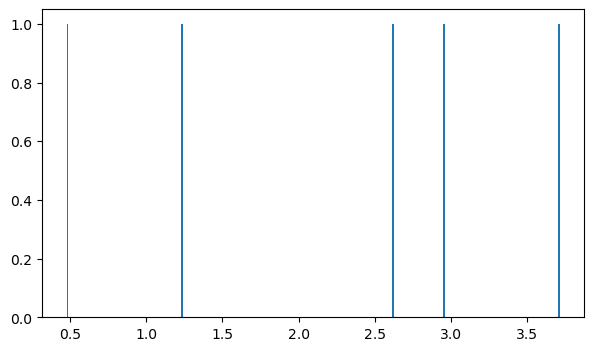

In [28]:
plt.hist(mpoints.values(), bins =250);

In [29]:
class ParallelModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
    
    def forward(self, x, m, frac, flen):
        return torch.stack([model(x, m, frac, flen)[0]
                            for model in self.models], -2)


In [30]:
# numpy add two arrays, expanding the smaller one on axis 0
def eadd(a, b):
    if isinstance(a, int): return b.copy();
    if a.shape[0] < b.shape[0]:
        a = np.pad(a, ((0, b.shape[0] - a.shape[0]), (0, 0)), mode = 'constant')
    elif a.shape[0] > b.shape[0]:
        b = np.pad(b, ((0, a.shape[0] - b.shape[0]), (0, 0)), mode = 'constant')
    return a + b

In [31]:
import time

In [32]:
all_pred_dict = {}; ct = 0
# for m in ms:#_, 
for _, ms in mgroups.items():
    models = []; m = ms[0];# print(json.loads(_))
    params = json.load(open(CODE_PATH + '/params/' + m + '.json', 'r'))
#     if params['frac_pwr_mult'] not in [2.36, 2.04, 1.81, 1.91, 1.88]: continue
    for m in ms:
        models.append(getModel(params, m ))    
    model = ParallelModel(models).to(device).eval()
    metadata, msubject, md = prep_metadata(defog_metadata, tdcsfog_metadata, daily_metadata, subjects,
                                      expanded = params['expanded'])
#     model = getModel(params, m)
    test_data, test_loader = getData(params, m, fogcount, metadata)
    start = time.time()
    spred_dict = inferParallel(model, test_loader)
#     spred_dict = infer(model, test_loader)
    print(time.time() - start)
    
    for k, v in spred_dict.items():
        all_pred_dict[k] = eadd(all_pred_dict.get(k, 0), 
                                v * mpoints[_])
    del test_data, test_loader, spred_dict
        
    ct += 1;
    print()
    del model#, models


{'dims': 384, 'frac_pwr_mult': 2.16, 'se_dropout': 0.2, 'dropout': 0.3, 'len_se': False, 'se_pact': 0.0, 'patch': 11, 'fix_final': False, 'nheads': 12, 'frac_se': False, 'm_adj_gn': 0.1, 'relabel': True, 'se_dims': 0, 'm_adj': False, 'frac_adj': True, 'len_adj': True, 'm_se': True, 'adj_gn': 0.5, 'expanded': False, 'frac_rand': 0.46, 'seq': 320}
{'act_layer': 'GELU', 'dropout': 0.3, 'pre_norm': True, 'final_mult': 4, 'xformer_init_2': 1.0, 'patch': 11, 'patch_dropout': 0.15, 'patch_act': 'LeakyReLU', 'alibi': 0, 'dims': 384, 'xformer_init_1': 1.0, 'nheads': 12, 'rnn': 'GRU', 'rel_pos': 'mlp', 'xformer_layers': 2, 'xformer_init_scale': 0.7, 'seq': 320}


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'dims': 384, 'frac_pwr_mult': 2.16, 'se_dropout': 0.2, 'dropout': 0.3, 'len_se': False, 'se_pact': 0.0, 'patch': 11, 'fix_final': False, 'nheads': 12, 'frac_se': False, 'm_adj_gn': 0.1, 'relabel': True, 'se_dims': 0, 'm_adj': False, 'frac_adj': True, 'len_adj': True, 'm_se': True, 'adj_gn': 0.5, 'expanded': False, 'frac_rand': 0.46, 'seq': 320}
{'act_layer': 'GELU', 'dropout': 0.3, 'pre_norm': True, 'final_mult': 4, 'xformer_init_2': 1.0, 'patch': 11, 'patch_dropout': 0.15, 'patch_act': 'LeakyReLU', 'alibi': 0, 'dims': 384, 'xformer_init_1': 1.0, 'nheads': 12, 'rnn': 'GRU', 'rel_pos': 'mlp', 'xformer_layers': 2, 'xformer_init_scale': 0.7, 'seq': 320}
{'dims': 384, 'frac_pwr_mult': 2.16, 'se_dropout': 0.2, 'dropout': 0.3, 'len_se': False, 'se_pact': 0.0, 'patch': 11, 'fix_final': False, 'nheads': 12, 'frac_se': False, 'm_adj_gn': 0.1, 'relabel': True, 'se_dims': 0, 'm_adj': False, 'frac_adj': True, 'len_adj': True, 'm_se': True, 'adj_gn': 0.5, 'expanded': False, 'frac_rand': 0.46, 'seq

/tmp/ipykernel_23/794707137.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  metadata.iloc[:, 1:] = metadata.iloc[:, 1:].astype(np.float32)


5
(253, 880, 5, 3) (253, 880, 1, 1) 253 253
(70966, 5, 3)
(1759, 5, 3)
[[0.02715978 0.09502907 0.04968544]
 [0.02376086 0.09549489 0.04008124]
 [0.02486324 0.09237064 0.0553765 ]
 [0.0179463  0.0901254  0.03819021]
 [0.02483981 0.09162747 0.04222225]]
6.460003852844238

{'dims': 384, 'frac_pwr_mult': 1.81, 'se_dropout': 0.3, 'dropout': 0.25, 'len_se': False, 'se_pact': 0.0, 'patch': 11, 'fix_final': True, 'nheads': 12, 'frac_se': False, 'm_adj_gn': 0.1, 'relabel': True, 'se_dims': 0, 'm_adj': True, 'frac_adj': True, 'len_adj': False, 'm_se': True, 'adj_gn': 0.5, 'expanded': False, 'frac_rand': 0.73, 'seq': 256}
{'act_layer': 'CELU', 'dropout': 0.25, 'pre_norm': True, 'final_mult': 4, 'xformer_init_2': 1.0, 'patch': 11, 'patch_dropout': 0, 'patch_act': 'Identity', 'alibi': 8, 'dims': 384, 'xformer_init_1': 1.0, 'nheads': 12, 'rnn': 'GRU', 'rel_pos': 'mlp', 'xformer_layers': 3, 'xformer_init_scale': 0.7, 'seq': 256}
{'dims': 384, 'frac_pwr_mult': 1.81, 'se_dropout': 0.3, 'dropout': 0.25,

/tmp/ipykernel_23/794707137.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  metadata.iloc[:, 1:] = metadata.iloc[:, 1:].astype(np.float32)


4
(314, 704, 4, 3) (314, 704, 1, 1) 314 314
(70819, 4, 3)
(1642, 4, 3)
[[0.02531227 0.07214028 0.04095671]
 [0.02578164 0.08239606 0.05058337]
 [0.02821609 0.07890119 0.04145826]
 [0.03000359 0.06063271 0.04319422]]
3.113924741744995

{'dims': 256, 'frac_pwr_mult': 2.01, 'se_dropout': 0.25, 'dropout': 0.2, 'len_se': False, 'se_pact': 0.0, 'patch': 9, 'fix_final': False, 'frac_se': False, 'm_adj_gn': 0.1, 'relabel': True, 'se_dims': 0, 'm_adj': True, 'frac_adj': True, 'len_adj': False, 'm_se': True, 'adj_gn': 0.5, 'expanded': False, 'frac_rand': 0.25, 'seq': 384}
{'act_layer': 'PReLU', 'dropout': 0.2, 'pre_norm': False, 'final_mult': 4, 'patch': 9, 'patch_dropout': 0, 'patch_act': 'CELU', 'alibi': 0, 'dims': 256, 'rnn': 'GRU', 'rel_pos': None, 'xformer_layers': 2, 'xformer_init_scale': 0.7, 'seq': 384}
{'dims': 256, 'frac_pwr_mult': 2.01, 'se_dropout': 0.25, 'dropout': 0.2, 'len_se': False, 'se_pact': 0.0, 'patch': 9, 'fix_final': False, 'frac_se': False, 'm_adj_gn': 0.1, 'relabel': Tru

/tmp/ipykernel_23/794707137.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  metadata.iloc[:, 1:] = metadata.iloc[:, 1:].astype(np.float32)


4
(256, 864, 4, 3) (256, 864, 1, 1) 256 256
(70848, 4, 3)
(1728, 4, 3)
[[0.02893273 0.07959076 0.05227751]
 [0.03262052 0.08482873 0.05490586]
 [0.02785042 0.08581421 0.0541337 ]
 [0.02911331 0.09548736 0.05104984]]
2.479499101638794

{'dims': 384, 'frac_pwr_mult': 2.43, 'se_dropout': 0.25, 'dropout': 0.15, 'len_se': False, 'se_pact': 0.0, 'patch': 10, 'fix_final': True, 'nheads': 12, 'frac_se': False, 'm_adj_gn': 0.1, 'relabel': True, 'se_dims': 16, 'm_adj': True, 'frac_adj': True, 'len_adj': True, 'm_se': True, 'adj_gn': 0.3, 'expanded': False, 'frac_rand': 0.89, 'seq': 224}
{'act_layer': 'GELU', 'dropout': 0.15, 'pre_norm': True, 'final_mult': 4, 'deberta': True, 'xformer_init_2': 1.0, 'patch': 10, 'patch_dropout': 0.1, 'patch_act': 'GELU', 'alibi': 0, 'dims': 384, 'xformer_init_1': 1.0, 'nheads': 12, 'rnn': 'LSTM', 'xformer_layers': 2, 'xformer_init_scale': 0.7, 'seq': 224}
{'dims': 384, 'frac_pwr_mult': 2.43, 'se_dropout': 0.25, 'dropout': 0.15, 'len_se': False, 'se_pact': 0.0, 'p

/tmp/ipykernel_23/794707137.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  metadata.iloc[:, 1:] = metadata.iloc[:, 1:].astype(np.float32)


4
(393, 560, 4, 3) (393, 560, 1, 1) 393 393
(70684, 4, 3)
(1492, 4, 3)
[[0.02229546 0.09062943 0.04809068]
 [0.02873504 0.10088325 0.05690193]
 [0.02626469 0.08292485 0.03770856]
 [0.02907671 0.09832387 0.05157768]]
3.964475393295288

{'dims': 384, 'frac_pwr_mult': 2.21, 'se_dropout': 0.2, 'dropout': 0.2, 'len_se': False, 'se_pact': 0.0, 'patch': 13, 'fix_final': True, 'nheads': 12, 'frac_se': False, 'm_adj_gn': 0.1, 'relabel': True, 'se_dims': 0, 'm_adj': True, 'frac_adj': True, 'len_adj': True, 'm_se': True, 'adj_gn': 0.3, 'expanded': False, 'frac_rand': 0.19, 'seq': 256}
{'act_layer': 'PReLU', 'dropout': 0.2, 'pre_norm': True, 'final_mult': 4, 'deberta': True, 'xformer_init_2': 1.0, 'patch': 13, 'patch_dropout': 0.15, 'patch_act': 'Tanh', 'alibi': 2, 'dims': 384, 'xformer_init_1': 1.0, 'nheads': 12, 'rnn': 'GRU', 'xformer_layers': 2, 'xformer_init_scale': 0.7, 'seq': 256}
{'dims': 384, 'frac_pwr_mult': 2.21, 'se_dropout': 0.2, 'dropout': 0.2, 'len_se': False, 'se_pact': 0.0, 'patch'

/tmp/ipykernel_23/794707137.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  metadata.iloc[:, 1:] = metadata.iloc[:, 1:].astype(np.float32)


4
(268, 832, 4, 3) (268, 832, 1, 1) 268 268
(70976, 4, 3)
(1663, 4, 3)
[[0.0222073  0.07123979 0.05201967]
 [0.01194922 0.07700805 0.05144074]
 [0.01917641 0.08135861 0.04413546]
 [0.01731316 0.09040815 0.04201276]]
3.523738384246826



In [33]:
preds = []
for k, v in all_pred_dict.items():
    true_len = len(load(k))
    print(k, len(v), true_len)
    v = cv2.resize(v, None, fx = 1, fy = SAMPLE)
    v = v[:true_len]
    v = np.pad(v, ((0, true_len - len(v) ), (0, 0)), mode = 'edge')
    
    df = pd.DataFrame(v / ct, columns = sample.columns, 
                index = ['{}_{}'.format(k.split('/')[-1].split('.')[0], i)
                             for i in range(len(v))],
                     dtype = np.float32)
    df.index.name = 'Id'
    preds.append(df)
preds = pd.concat(preds)#.reset_index()
print(len(preds))
preds.tail()

test/defog/02ab235146.csv 70422 281688
test/tdcsfog/003f117e14.csv 1171 4682
286370


,StartHesitation,Turn,Walking
Id,,,
003f117e14_4677,0.969125,1.088453,0.857234
003f117e14_4678,0.951290,1.060799,0.858686
003f117e14_4679,0.848943,0.978044,0.811633
003f117e14_4680,0.746597,0.895288,0.764580
003f117e14_4681,0.644250,0.812532,0.717527


In [34]:
if len(fog_files) == 2:
    preds = preds[:-1]#.head(200)

In [35]:
if len(preds) != len(sample): 
    preds = pd.concat((preds.reindex(
        sorted(list(set(sample.index) & set(preds.index))) ), 
                    sample.reindex(
        sorted(list(set(sample.index) - set(preds.index))) ) ))
len(preds)

286370

In [36]:
preds.tail(5)

,StartHesitation,Turn,Walking
Id,,,
02ab235146_99996,2.242917,5.394113,3.205467
02ab235146_99997,2.242001,5.385119,3.199695
02ab235146_99998,2.239373,5.377664,3.195646
02ab235146_99999,2.235034,5.371747,3.193320
003f117e14_4681,0.000000,0.000000,0.000000


In [37]:
assert len(preds) == len(sample) and all(preds.columns == sample.columns)
assert sorted(preds.index.tolist()) == sorted(sample.index.tolist())

In [38]:
preds.to_csv('submission.csv')#, index = False)

In [39]:
preds2 = pd.read_csv('submission.csv')
sample2 = pd.read_csv(getFile('sample_submission.csv'))
assert len(preds2) == len(sample2) and all(preds2.columns == sample2.columns)
assert sorted(preds2.index.tolist()) == sorted(sample2.index.tolist())

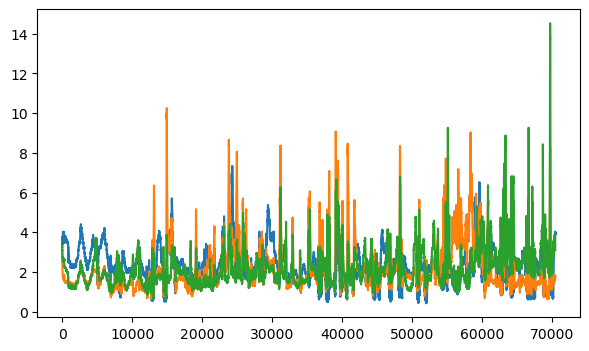

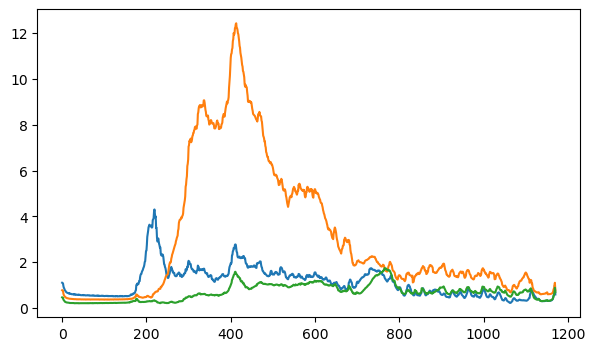

In [40]:
for k in fog_files[:2]:
    plt.figure()
    plt.plot(all_pred_dict[k] / ct)

In [41]:
np.concatenate(list(all_pred_dict.values())).mean(0)

array([10.999993, 10.999912, 10.99998 ], dtype=float32)